[INFO   ] [Logger      ] Record log in C:\Users\Lenovo\.kivy\logs\kivy_23-03-15_1.txt
[INFO   ] [deps        ] Successfully imported "kivy_deps.angle" 0.3.3
[INFO   ] [deps        ] Successfully imported "kivy_deps.glew" 0.3.1
[INFO   ] [deps        ] Successfully imported "kivy_deps.sdl2" 0.4.5
[INFO   ] [Kivy        ] v2.1.0
[INFO   ] [Kivy        ] Installed at "C:\Users\Lenovo\anaconda3\envs\tf\lib\site-packages\kivy\__init__.py"
[INFO   ] [Python      ] v3.9.12 (main, Apr  4 2022, 05:22:27) [MSC v.1916 64 bit (AMD64)]
[INFO   ] [Python      ] Interpreter at "C:\Users\Lenovo\anaconda3\envs\tf\python.exe"
[INFO   ] [Logger      ] Purge log fired. Processing...
[INFO   ] [Logger      ] Purge finished!
[INFO   ] [Factory     ] 189 symbols loaded
[INFO   ] [Image       ] Providers: img_tex, img_dds, img_sdl2, img_pil (img_ffpyplayer ignored)
[INFO   ] [Text        ] Provider: sdl2
[INFO   ] [Window      ] Provider: sdl2
[INFO   ] [GL          ] Using the "OpenGL" graphics system
[INFO 

saving brain...


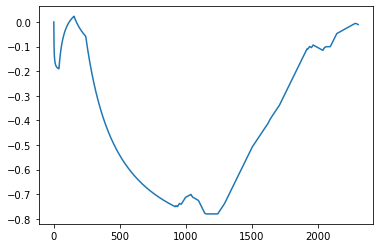

loading last saved brain...
=> loading checkpoint... 
done !


[INFO   ] [Base        ] Leaving application in progress...


In [1]:
# Self Driving Car

# Importing the libraries
import numpy as np
from random import random, randint
import matplotlib.pyplot as plt
import time

# Importing the Kivy packages
from kivy.app import App
from kivy.uix.widget import Widget
from kivy.uix.button import Button
from kivy.graphics import Color, Ellipse, Line
from kivy.config import Config
from kivy.properties import NumericProperty, ReferenceListProperty, ObjectProperty
from kivy.vector import Vector
from kivy.clock import Clock

# Importing the Dqn object from our AI in ia.py
from ai import Dqn

# Adding this line if we don't want the right click to put a red point
Config.set('input', 'mouse', 'mouse,multitouch_on_demand')

# Introducing last_x and last_y, used to keep the last point in memory when we draw the sand on the map
last_x = 0
last_y = 0
n_points = 0 # the total number of points in the last drawing
length = 0 # the length of the last drawing

# Getting our AI, which we call "brain", and that contains our neural network that represents our Q-function
brain = Dqn(5,3,0.9) # 5 sensors, 3 actions, gama = 0.9
action2rotation = [0,20,-20] # action = 0 => no rotation, action = 1 => rotate 20 degres, action = 2 => rotate -20 degres
last_reward = 0 # initializing the last reward
scores = [] # initializing the mean score curve (sliding window of the rewards) with respect to time

# Initializing the map
first_update = True # using this trick to initialize the map only once
def init():
    global sand # sand is an array that has as many cells as our graphic interface has pixels. Each cell has a one if there is sand, 0 otherwise.
    global goal_x # x-coordinate of the goal (where the car has to go, that is the airport or the downtown)
    global goal_y # y-coordinate of the goal (where the car has to go, that is the airport or the downtown)
    sand = np.zeros((longueur,largeur)) # initializing the sand array with only zeros
    goal_x = 20 # the goal to reach is at the upper left of the map (the x-coordinate is 20 and not 0 because the car gets bad reward if it touches the wall)
    goal_y = largeur - 20 # the goal to reach is at the upper left of the map (y-coordinate)
    first_update = False # trick to initialize the map only once

# Initializing the last distance
last_distance = 0

# Creating the car class (to understand "NumericProperty" and "ReferenceListProperty", see kivy tutorials: https://kivy.org/docs/tutorials/pong.html)

class Car(Widget):

    angle = NumericProperty(0) # initializing the angle of the car (angle between the x-axis of the map and the axis of the car)
    rotation = NumericProperty(0) # initializing the last rotation of the car (after playing the action, the car does a rotation of 0, 20 or -20 degrees)
    velocity_x = NumericProperty(0) # initializing the x-coordinate of the velocity vector
    velocity_y = NumericProperty(0) # initializing the y-coordinate of the velocity vector
    velocity = ReferenceListProperty(velocity_x, velocity_y) # velocity vector
    sensor1_x = NumericProperty(0) # initializing the x-coordinate of the first sensor (the one that looks forward)
    sensor1_y = NumericProperty(0) # initializing the y-coordinate of the first sensor (the one that looks forward)
    sensor1 = ReferenceListProperty(sensor1_x, sensor1_y) # first sensor vector
    sensor2_x = NumericProperty(0) # initializing the x-coordinate of the second sensor (the one that looks 30 degrees to the left)
    sensor2_y = NumericProperty(0) # initializing the y-coordinate of the second sensor (the one that looks 30 degrees to the left)
    sensor2 = ReferenceListProperty(sensor2_x, sensor2_y) # second sensor vector
    sensor3_x = NumericProperty(0) # initializing the x-coordinate of the third sensor (the one that looks 30 degrees to the right)
    sensor3_y = NumericProperty(0) # initializing the y-coordinate of the third sensor (the one that looks 30 degrees to the right)
    sensor3 = ReferenceListProperty(sensor3_x, sensor3_y) # third sensor vector
    signal1 = NumericProperty(0) # initializing the signal received by sensor 1
    signal2 = NumericProperty(0) # initializing the signal received by sensor 2
    signal3 = NumericProperty(0) # initializing the signal received by sensor 3

    def move(self, rotation):
        self.pos = Vector(*self.velocity) + self.pos # updating the position of the car according to its last position and velocity
        self.rotation = rotation # getting the rotation of the car
        self.angle = self.angle + self.rotation # updating the angle
        self.sensor1 = Vector(30, 0).rotate(self.angle) + self.pos # updating the position of sensor 1
        self.sensor2 = Vector(30, 0).rotate((self.angle+30)%360) + self.pos # updating the position of sensor 2
        self.sensor3 = Vector(30, 0).rotate((self.angle-30)%360) + self.pos # updating the position of sensor 3
        self.signal1 = int(np.sum(sand[int(self.sensor1_x)-10:int(self.sensor1_x)+10, int(self.sensor1_y)-10:int(self.sensor1_y)+10]))/400. # getting the signal received by sensor 1 (density of sand around sensor 1)
        self.signal2 = int(np.sum(sand[int(self.sensor2_x)-10:int(self.sensor2_x)+10, int(self.sensor2_y)-10:int(self.sensor2_y)+10]))/400. # getting the signal received by sensor 2 (density of sand around sensor 2)
        self.signal3 = int(np.sum(sand[int(self.sensor3_x)-10:int(self.sensor3_x)+10, int(self.sensor3_y)-10:int(self.sensor3_y)+10]))/400. # getting the signal received by sensor 3 (density of sand around sensor 3)
        if self.sensor1_x > longueur-10 or self.sensor1_x<10 or self.sensor1_y>largeur-10 or self.sensor1_y<10: # if sensor 1 is out of the map (the car is facing one edge of the map)
            self.signal1 = 1. # sensor 1 detects full sand
        if self.sensor2_x > longueur-10 or self.sensor2_x<10 or self.sensor2_y>largeur-10 or self.sensor2_y<10: # if sensor 2 is out of the map (the car is facing one edge of the map)
            self.signal2 = 1. # sensor 2 detects full sand
        if self.sensor3_x > longueur-10 or self.sensor3_x<10 or self.sensor3_y>largeur-10 or self.sensor3_y<10: # if sensor 3 is out of the map (the car is facing one edge of the map)
            self.signal3 = 1. # sensor 3 detects full sand

class Ball1(Widget): # sensor 1 (see kivy tutorials: kivy https://kivy.org/docs/tutorials/pong.html)
    pass
class Ball2(Widget): # sensor 2 (see kivy tutorials: kivy https://kivy.org/docs/tutorials/pong.html)
    pass
class Ball3(Widget): # sensor 3 (see kivy tutorials: kivy https://kivy.org/docs/tutorials/pong.html)
    pass

# Creating the game class (to understand "ObjectProperty", see kivy tutorials: kivy https://kivy.org/docs/tutorials/pong.html)

class Game(Widget):

    car = ObjectProperty(None) # getting the car object from our kivy file
    ball1 = ObjectProperty(None) # getting the sensor 1 object from our kivy file
    ball2 = ObjectProperty(None) # getting the sensor 2 object from our kivy file
    ball3 = ObjectProperty(None) # getting the sensor 3 object from our kivy file

    def serve_car(self): # starting the car when we launch the application
        self.car.center = self.center # the car will start at the center of the map
        self.car.velocity = Vector(6, 0) # the car will start to go horizontally to the right with a speed of 6

    def update(self, dt): # the big update function that updates everything that needs to be updated at each discrete time t when reaching a new state (getting new signals from the sensors)

        global brain # specifying the global variables (the brain of the car, that is our AI)
        global last_reward # specifying the global variables (the last reward)
        global scores # specifying the global variables (the means of the rewards)
        global last_distance # specifying the global variables (the last distance from the car to the goal)
        global goal_x # specifying the global variables (x-coordinate of the goal)
        global goal_y # specifying the global variables (y-coordinate of the goal)
        global longueur # specifying the global variables (width of the map)
        global largeur # specifying the global variables (height of the map)

        longueur = self.width # width of the map (horizontal edge)
        largeur = self.height # height of the map (vertical edge)
        if first_update: # trick to initialize the map only once
            init()

        xx = goal_x - self.car.x # difference of x-coordinates between the goal and the car
        yy = goal_y - self.car.y # difference of y-coordinates between the goal and the car
        orientation = Vector(*self.car.velocity).angle((xx,yy))/180. # direction of the car with respect to the goal (if the car is heading perfectly towards the goal, then orientation = 0)
        last_signal = [self.car.signal1, self.car.signal2, self.car.signal3, orientation, -orientation] # our input state vector, composed of the three signals received by the three sensors, plus the orientation and -orientation
        action = brain.update(last_reward, last_signal) # playing the action from our ai (the object brain of the dqn class)
        scores.append(brain.score()) # appending the score (mean of the last 100 rewards to the reward window)
        rotation = action2rotation[action] # converting the action played (0, 1 or 2) into the rotation angle (0°, 20° or -20°)
        self.car.move(rotation) # moving the car according to this last rotation angle
        distance = np.sqrt((self.car.x - goal_x)**2 + (self.car.y - goal_y)**2) # getting the new distance between the car and the goal right after the car moved
        self.ball1.pos = self.car.sensor1 # updating the position of the first sensor (ball1) right after the car moved
        self.ball2.pos = self.car.sensor2 # updating the position of the second sensor (ball2) right after the car moved
        self.ball3.pos = self.car.sensor3 # updating the position of the third sensor (ball3) right after the car moved

        if sand[int(self.car.x),int(self.car.y)] > 0: # if the car is on the sand
            self.car.velocity = Vector(1, 0).rotate(self.car.angle) # it is slowed down (speed = 1)
            last_reward = -1 # and reward = -1
        else: # otherwise
            self.car.velocity = Vector(6, 0).rotate(self.car.angle) # it goes to a normal speed (speed = 6)
            last_reward = -0.2 # and it gets bad reward (-0.2)
            if distance < last_distance: # however if it getting close to the goal
                last_reward = 0.1 # it still gets slightly positive reward 0.1

        if self.car.x < 10: # if the car is in the left edge of the frame
            self.car.x = 10 # it is not slowed down
            last_reward = -1 # but it gets bad reward -1
        if self.car.x > self.width-10: # if the car is in the right edge of the frame
            self.car.x = self.width-10 # it is not slowed down
            last_reward = -1 # but it gets bad reward -1
        if self.car.y < 10: # if the car is in the bottom edge of the frame
            self.car.y = 10 # it is not slowed down
            last_reward = -1 # but it gets bad reward -1
        if self.car.y > self.height-10: # if the car is in the upper edge of the frame
            self.car.y = self.height-10 # it is not slowed down
            last_reward = -1 # but it gets bad reward -1

        if distance < 100: # when the car reaches its goal
            goal_x = self.width - goal_x # the goal becomes the bottom right corner of the map (the downtown), and vice versa (updating of the x-coordinate of the goal)
            goal_y = self.height - goal_y # the goal becomes the bottom right corner of the map (the downtown), and vice versa (updating of the y-coordinate of the goal)

        # Updating the last distance from the car to the goal
        last_distance = distance

# Painting for graphic interface (see kivy tutorials: https://kivy.org/docs/tutorials/firstwidget.html)

class MyPaintWidget(Widget):

    def on_touch_down(self, touch): # putting some sand when we do a left click
        global length,n_points,last_x,last_y
        with self.canvas:
            Color(0.8,0.7,0)
            d=10.
            touch.ud['line'] = Line(points = (touch.x, touch.y), width = 10)
            last_x = int(touch.x)
            last_y = int(touch.y)
            n_points = 0
            length = 0
            sand[int(touch.x),int(touch.y)] = 1

    def on_touch_move(self, touch): # putting some sand when we move the mouse while pressing left
        global length,n_points,last_x,last_y
        if touch.button=='left':
            touch.ud['line'].points += [touch.x, touch.y]
            x = int(touch.x)
            y = int(touch.y)
            length += np.sqrt(max((x - last_x)**2 + (y - last_y)**2, 2))
            n_points += 1.
            density = n_points/(length)
            touch.ud['line'].width = int(20*density + 1)
            sand[int(touch.x) - 10 : int(touch.x) + 10, int(touch.y) - 10 : int(touch.y) + 10] = 1
            last_x = x
            last_y = y

# API and switches interface (see kivy tutorials: https://kivy.org/docs/tutorials/pong.html)

class CarApp(App):

    def build(self): # building the app
        parent = Game()
        parent.serve_car()
        Clock.schedule_interval(parent.update, 1.0 / 60.0)
        self.painter = MyPaintWidget()
        clearbtn = Button(text='clear')
        savebtn = Button(text='save',pos=(parent.width,0))
        loadbtn = Button(text='load',pos=(2*parent.width,0))
        clearbtn.bind(on_release=self.clear_canvas)
        savebtn.bind(on_release=self.save)
        loadbtn.bind(on_release=self.load)
        parent.add_widget(self.painter)
        parent.add_widget(clearbtn)
        parent.add_widget(savebtn)
        parent.add_widget(loadbtn)
        return parent

    def clear_canvas(self, obj): # clear button
        global sand
        self.painter.canvas.clear()
        sand = np.zeros((longueur,largeur))

    def save(self, obj): # save button
        print("saving brain...")
        brain.save()
        plt.plot(scores)
        plt.show()

    def load(self, obj): # load button
        print("loading last saved brain...")
        brain.load()

# Running the app
if __name__ == '__main__':
    CarApp().run()
